# Hit distribution of the event

This notebook reproduces Figure 7 and Figure 11 from the publication.

Figure 7: Time residual distribution of the hits of KM3-230213A, defined as the difference between the time of arrival of the detected photons in the event and the expected time from Cherenkov radiation, induced by a relativistic muon.

Figure 11: Distribution of the computed emission point of photons in KM3-230213A along the reconstructed muon trajectory, represented by the distance to the location of the muon at t = t0.

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../src")

from cherenkov import Cherenkov, emission_points
from readhits import read_zipped_json, merge_multi_hits

evt = read_zipped_json("../data/event/KM3-230213A_allhits.json.gz")

merge_multi_hits(evt)

original hits 28086
merged hits 26886


## Hit time residuals

In [2]:
def residual_hist(hitlist, track, distance_range=(0, 100), first_hits=False):
    """Make a residual histogram for a given track and hitlist.
    
    If first_hits is True, only the first hit on each DOM inside the
    histogram range is used. For this, hits must be time-sorted.
    """
    bins = np.linspace(-20, 120, 71)  # 70 bins from -20 to 120 ns
    hist_values = np.zeros(len(bins) - 1)
    seen = set()
    
    for hit in hitlist:
        C = Cherenkov(track, hit.pos)
        
        if distance_range[0] <= C.d_closest < distance_range[1]:
            residual = hit.t - C.time
            
            if residual < bins[0]:
                continue
            
            if first_hits and (hit.dom_id, hit.channel_id) in seen:
                continue
            
            seen.add((hit.dom_id, hit.channel_id))
            bin_index = np.digitize(residual, bins) - 1
            if 0 <= bin_index < len(hist_values):
                hist_values[bin_index] += 1
    
    return bins, hist_values

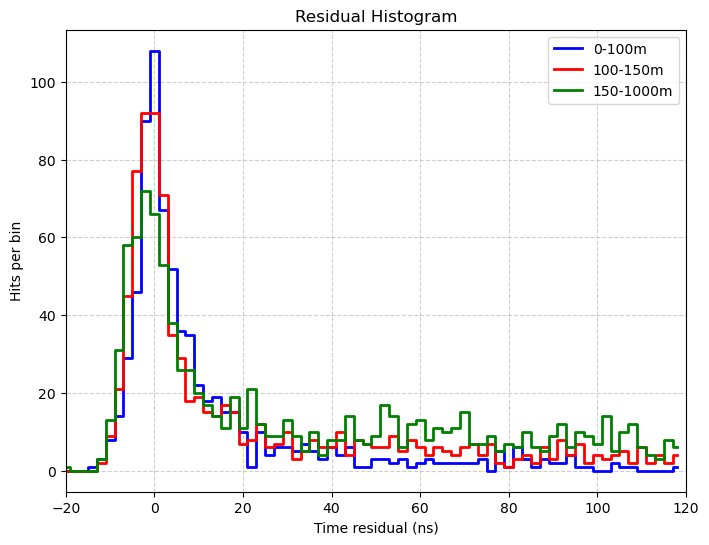

In [3]:
# Generate histograms
bins1, hist1 = residual_hist(evt.hits, evt.reconstructed_track, (0, 100), True)
bins2, hist2 = residual_hist(evt.hits, evt.reconstructed_track, (100, 150), True)
bins3, hist3 = residual_hist(evt.hits, evt.reconstructed_track, (150, 1000), True)

# Plot histograms
plt.figure(figsize=(8, 6))
plt.step(bins1[:-1], hist1, where='mid', label='0-100m', linewidth=2, color='blue')
plt.step(bins2[:-1], hist2, where='mid', label='100-150m', linewidth=2, color='red')
plt.step(bins3[:-1], hist3, where='mid', label='150-1000m', linewidth=2, color='green')
plt.xlim(-20, 120)
plt.xlabel("Time residual (ns)")
plt.ylabel("Hits per bin")
plt.title("Residual Histogram")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Emission point along the track

In [4]:
def emission_along_track(track, hitlist, residual_range=(-50, 1000)):
    bins = np.linspace(0, 600, 301)  # 300 bins from 0 to 600
    hist_values = np.zeros(len(bins) - 1)
    
    for hit in hitlist:
        C = Cherenkov(track, hit.pos)
        residual = hit.t - C.time
        
        if not (residual_range[0] <= residual < residual_range[1]):
            continue
        
        pt = emission_points(track, hit)
        if not pt:
            continue
        
        bin_index = np.digitize(pt[0], bins) - 1
        if 0 <= bin_index < len(hist_values):
            hist_values[bin_index] += 1
    
    return bins, hist_values

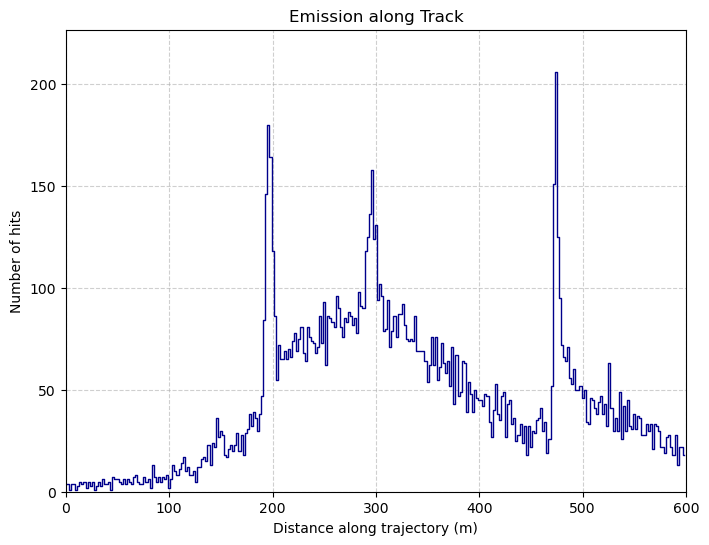

In [5]:
# Generate emission histogram
bins0, hist0 = emission_along_track(evt.reconstructed_track, evt.hits)

# Plot emission histogram
plt.figure(figsize=(8, 6))
plt.step(bins0[:-1], hist0, where='mid', color='darkblue', linewidth=1)
plt.xlabel("Distance along trajectory (m)")
plt.ylabel("Number of hits")
plt.title("Emission along Track")
plt.xlim(0, 600)
plt.ylim(0, max(hist0) * 1.1)  # Adjust y-axis to show the full range without filling
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()